<a href="https://colab.research.google.com/github/JoeArmel/JoeArmel/blob/main/0606_Final_ElectricitySVR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MODELE PREDICTIF CONSOMMATION ELECTRICITE**


---



##**1. Installation du module de construction des fichiers *pmml*.**

In [ ]:
!pip install sklearn2pmml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 6.1 MB/s 
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.83.0-py3-none-any.whl size=6267699 sha256=2f993e37c22aa312b5702aaab39a5d6a47afd6d536162f72e82784b8f66b4fe3
  Stored in directory: /root/.cache/pip/wheels/97/6f/6e/711f820c572619b94c51830a0ca64efa699aa878548acfb13f
Successfully built sklearn2pmml


In [ ]:
# Connexion de Colab à Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##**2. Importation des modules nécessaires à l'exploitation des données**

In [ ]:
import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import make_pmml_pipeline, sklearn2pmml

import numpy as np
import pandas as pd
from sklearn_pandas import DataFrameMapper

from sklearn import model_selection, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn import svm 

import matplotlib.pyplot as plt
import seaborn as sns

###**Chargement des données**

In [ ]:
# Importation des données et chargement dans un Dataframe
elect = pd.read_csv('/content/gdrive/MyDrive/PFE_Models/DonnéesElectricté13_22.csv', sep=";")

#Affichage des dix premières lignes de données
elect.head(10)

Code_Region  Année  Mois  Nbre Jours fériés  Vitesse Moyenne Vent (m/s)  \
0           84   2013     1                  1                        3.15   
1           27   2013     1                  1                        2.69   
2           53   2013     1                  1                        4.94   
3           24   2013     1                  1                        3.06   
4           44   2013     1                  1                        3.03   
5           32   2013     1                  1                        4.28   
6           11   2013     1                  1                        3.15   
7           28   2013     1                  1                        4.59   
8           75   2013     1                  1                        3.46   
9           76   2013     1                  1                        3.38   

   Taux Moyen Humidité  Hauteur Moyenne Neige (m)  \
0                81.05                       0.00   
1                88.55                       0.00   
2                85.30                       0.00   
3                89.80                       0.00   
4                88.33                       0.00   
5                89.69                       0.02   
6                87.77                       0.01   
7                87.05                       0.00   
8                88.40                       0.00   
9                80.12                       0.00   

   Moyenne_Temperature min (12h)  Min_Temperature min  \
0                           0.08                  0.0   
1                          -0.01                  0.0   
2                           1.39                  0.0   
3                           0.65                  0.0   
4                           0.10                  0.0   
5                           0.27                  0.0   
6                           0.48                  0.0   
7                           0.85                  0.0   
8                           0.93                  0.0   
9                           0.50                  0.0   

   Moyenne_Temperature min (24h)  Max_Temperature min  \
0                            0.0                  0.0   
1                            0.0                  0.0   
2                            0.0                  0.0   
3                            0.0                  0.0   
4                            0.0                  0.0   
5                            0.0                  0.0   
6                            0.0                  0.0   
7                            0.0                  0.0   
8                            0.0                  0.0   
9                            0.0                  0.0   

   Temperature Moyenne (°C)  Min_Temperature max  \
0                      2.78                  0.0   
1                      1.99                  0.0   
2                      7.15                  0.0   
3                      4.15                  0.0   
4                      2.11                  0.0   
5                      2.73                  0.0   
6                      3.44                  0.0   
7                      4.82                  0.0   
8                      5.52                  0.0   
9                      5.00                  0.0   

   Moyenne_Temperature max (12h)  Max_Temperature max  \
0                           1.22                  0.0   
1                           0.84                  0.0   
2                           2.13                  0.0   
3                           1.42                  0.0   
4                           0.86                  0.0   
5                           1.03                  0.0   
6                           1.18                  0.0   
7                           1.52                  0.0   
8                           1.82                  0.0   
9                           1.89                  0.0   

   Moyenne_Temperature max (24h)  Temperature du sol  Précipitation (mm)  \
0                          

##**3. Analyse des corrélations**

###**3.1 Analyse des distributions croisées de variables**

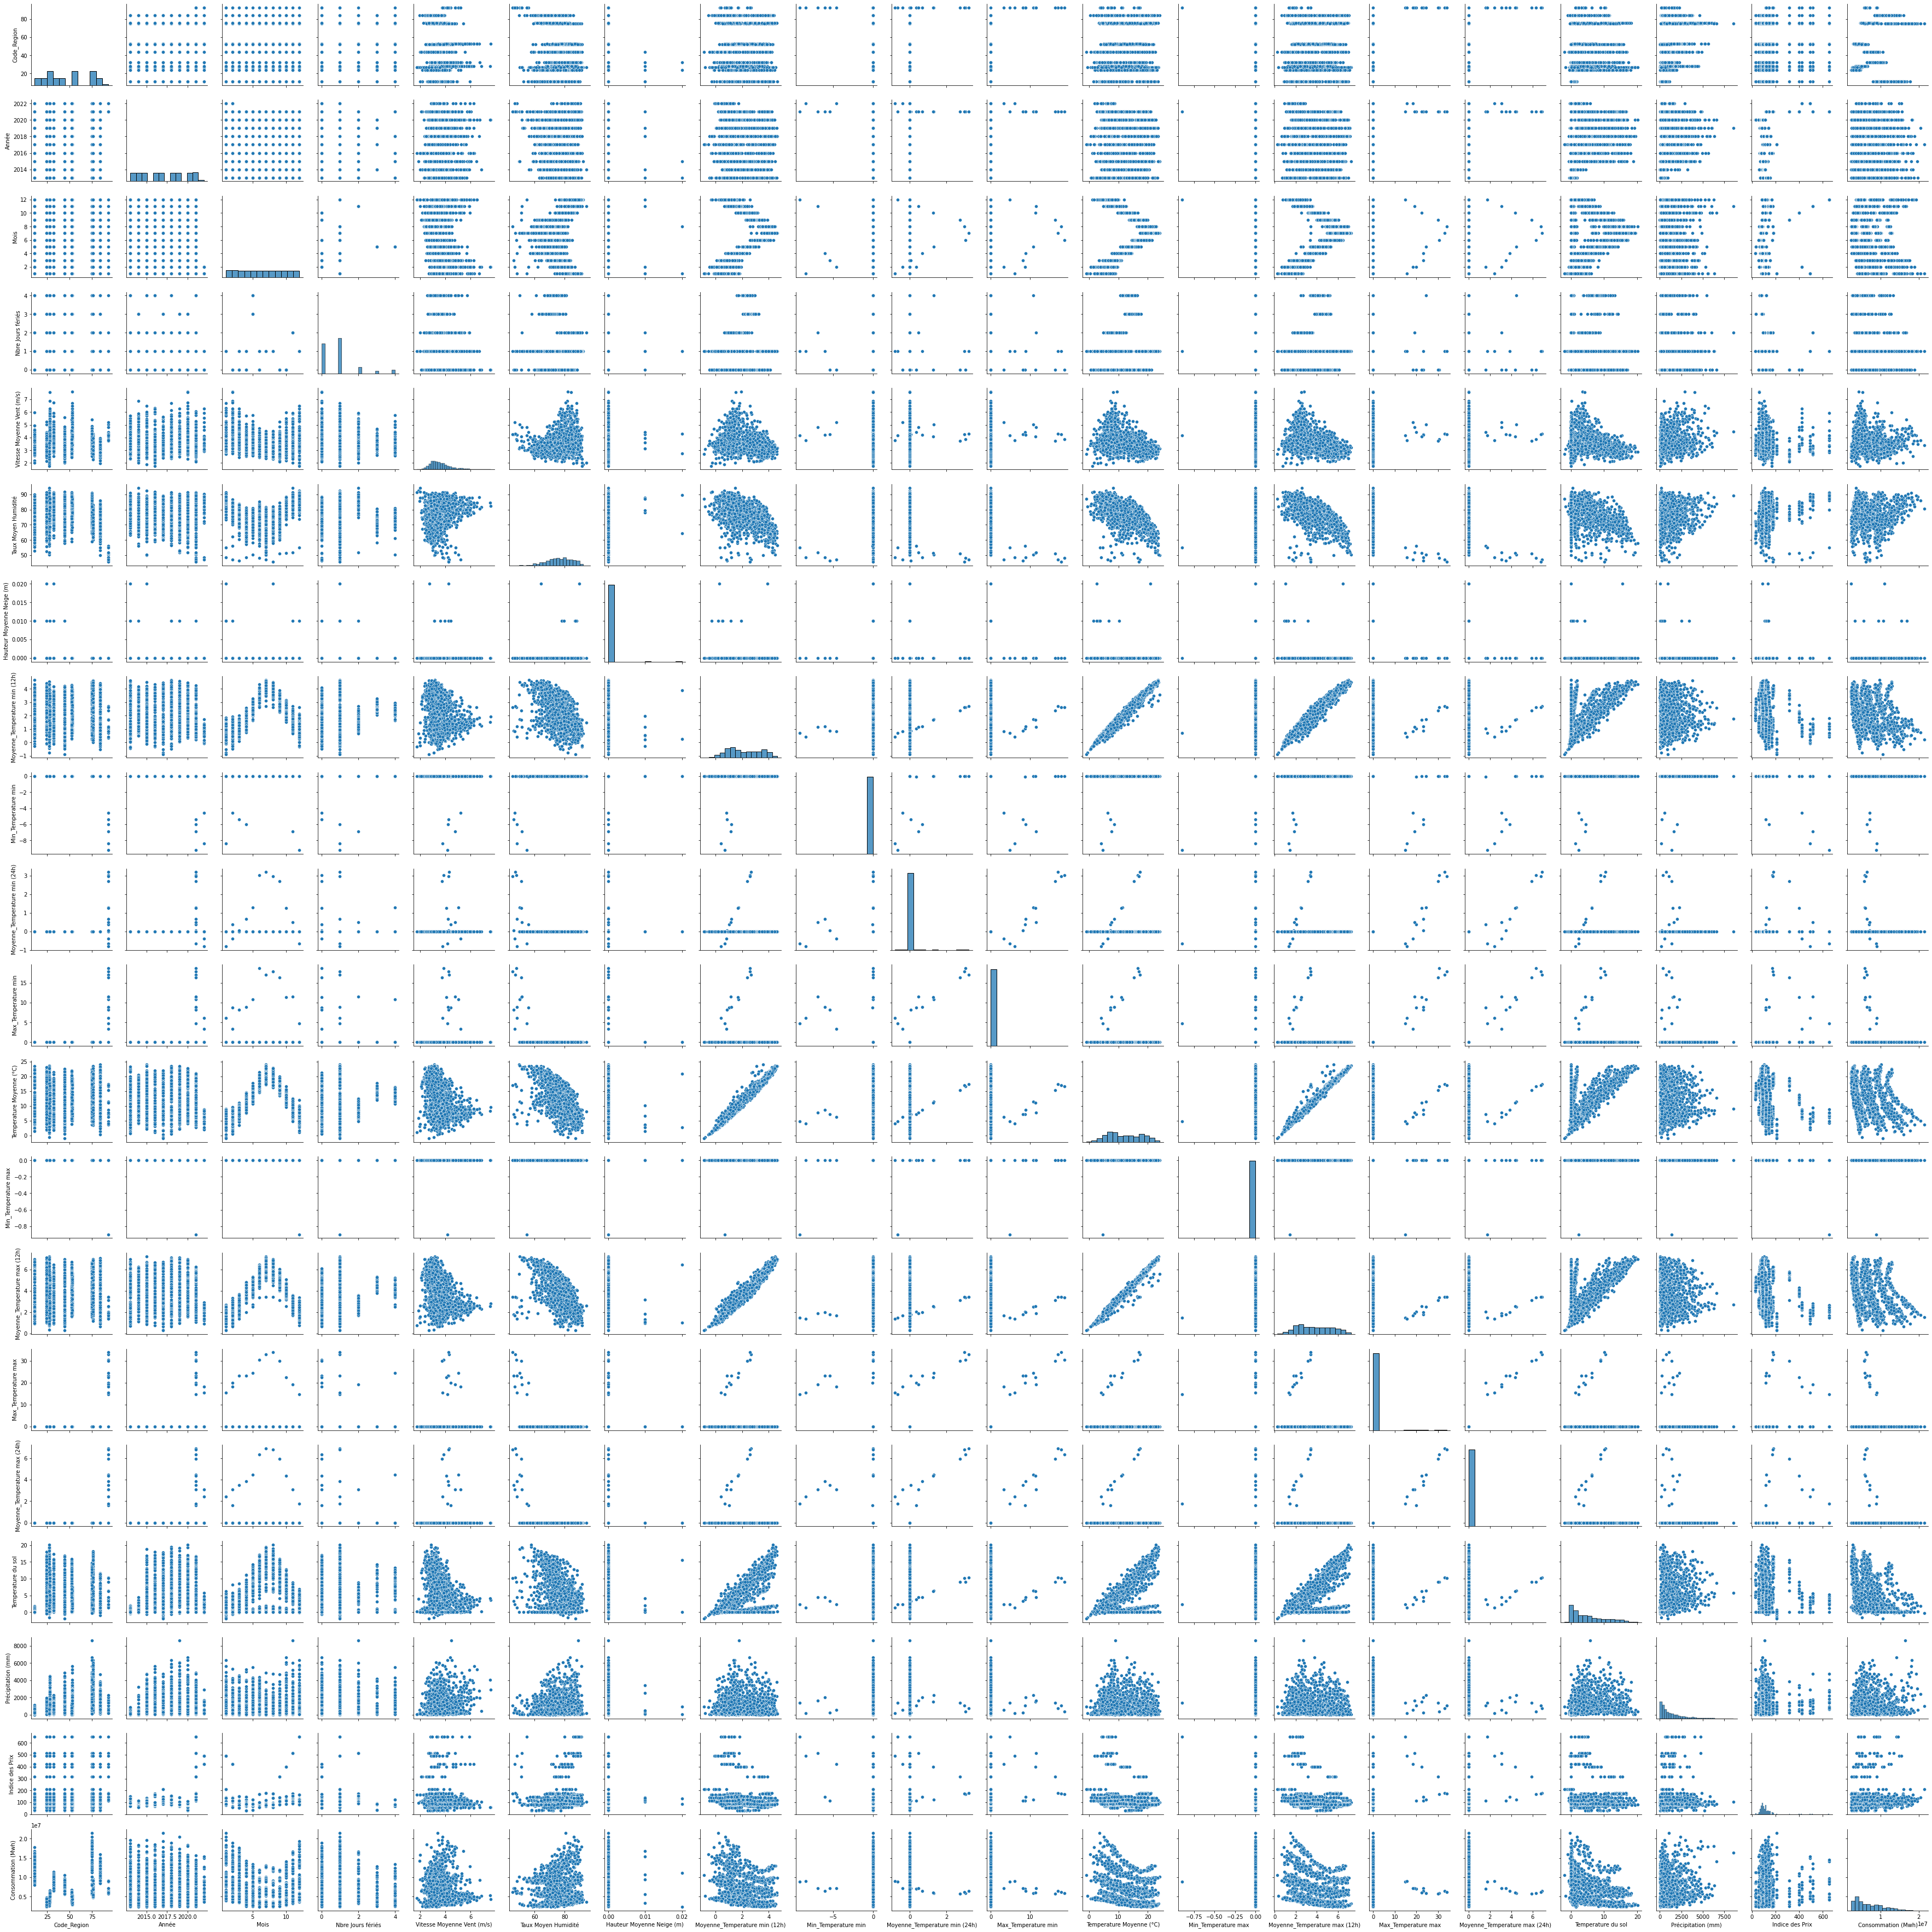

In [ ]:
sns.pairplot(elect);

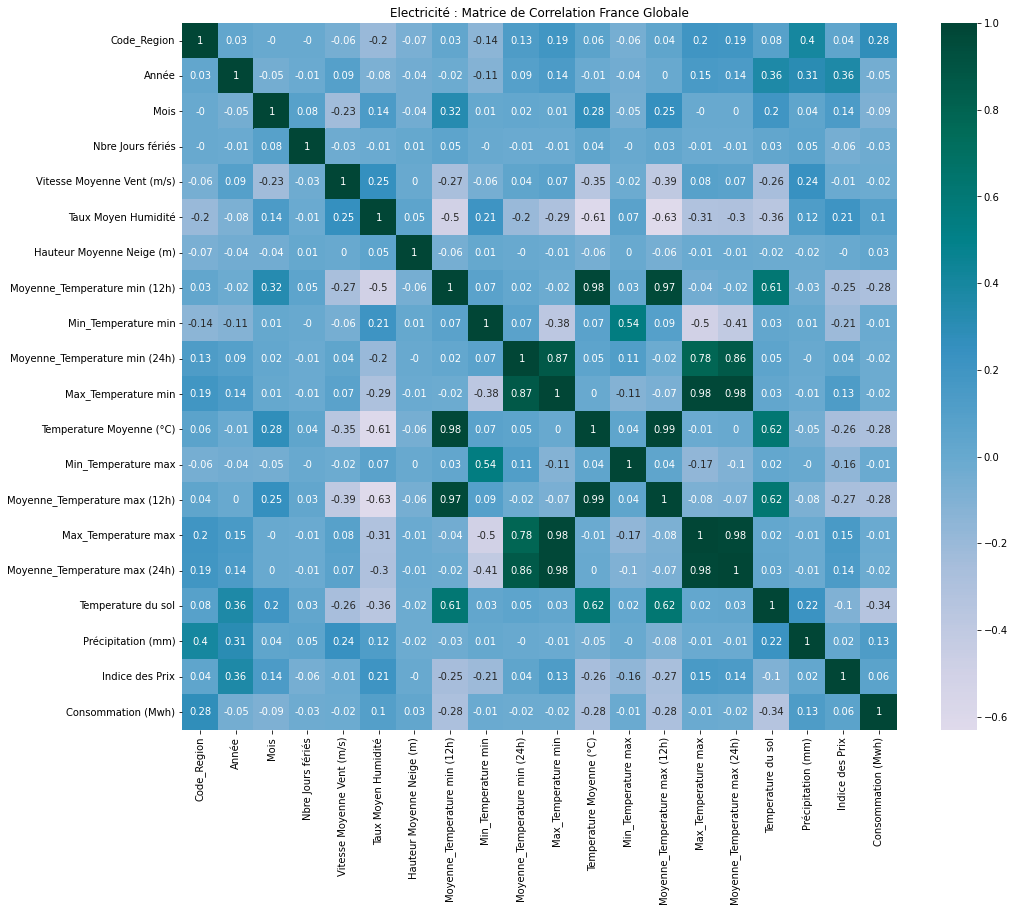

In [ ]:
# Affichage de la matrice de corrélation globale et sauvegarde du graphe généré

fig, ax = plt.subplots(figsize = (16, 13))
ax = sns.heatmap(elect.corr().round(2), annot=True, cmap = 'PuBuGn', center=0) 
plt.title('Electricité : Matrice de Correlation France Globale')
fig.savefig('gdrive/MyDrive/PFE_Models/Electricity_Global_Correlation_Matrix.png')
plt.show();

La matrice de corrélation ne permet pas de déceller des variables qui se démarquent significativement par leur impact (positif ou négatif) sur la consommation d'électricité.

Afin d'affiner notre analyse, nous effectuerons un filtre sur chaque région pour identifier si elles existent, les variables ayant un grand impact sur la consommation.

###**3.2 Analyses régionales des corrélations**

In [ ]:
#Récupération du code de chaque région
code = elect["Code_Region"].unique()

##code = array([84, 27, 53, 24, 44, 32, 11, 28, 75, 76, 52, 93])

# Sélection des données correpondantes à chaque région présente dans mon dataset gaz et stockage dans des variables.
#e_ARA = elect.loc[elect['Code_Region']==code[0]]      #Auvergne Rhone Alpe
#e_BFC = elect.loc[elect['Code_Region']==code[1]]      #Bourgogne Franche Comte
#e_BRE = elect.loc[elect['Code_Region']==code[2]]      #Bretagne
#e_CVL = elect.loc[elect['Code_Region']==code[3]]      #Centre Val de Loire
#e_GDE = elect.loc[elect['Code_Region']==code[4]]      #Grand Est
#e_HDF = elect.loc[elect['Code_Region']==code[5]]      #Hauts de France
#e_IDF = elect.loc[elect['Code_Region']==code[6]]      #Ile de France
#e_NOR = elect.loc[elect['Code_Region']==code[7]]      #Normandie
#e_NAQ = elect.loc[elect['Code_Region']==code[8]]      #Nouvelle Aquitaine
#e_OCC = elect.loc[elect['Code_Region']==code[9]]      #Occitanie
#e_PDL = elect.loc[elect['Code_Region']==code[10]]     #Pays de la Loire
#e_PACA = elect.loc[elect['Code_Region']==code[11]]    #Provence Alpes Côte d'Azur

####**Affichage de la matrice de distribution croisée des variables pour la région Auvergne Rhône Alpes**

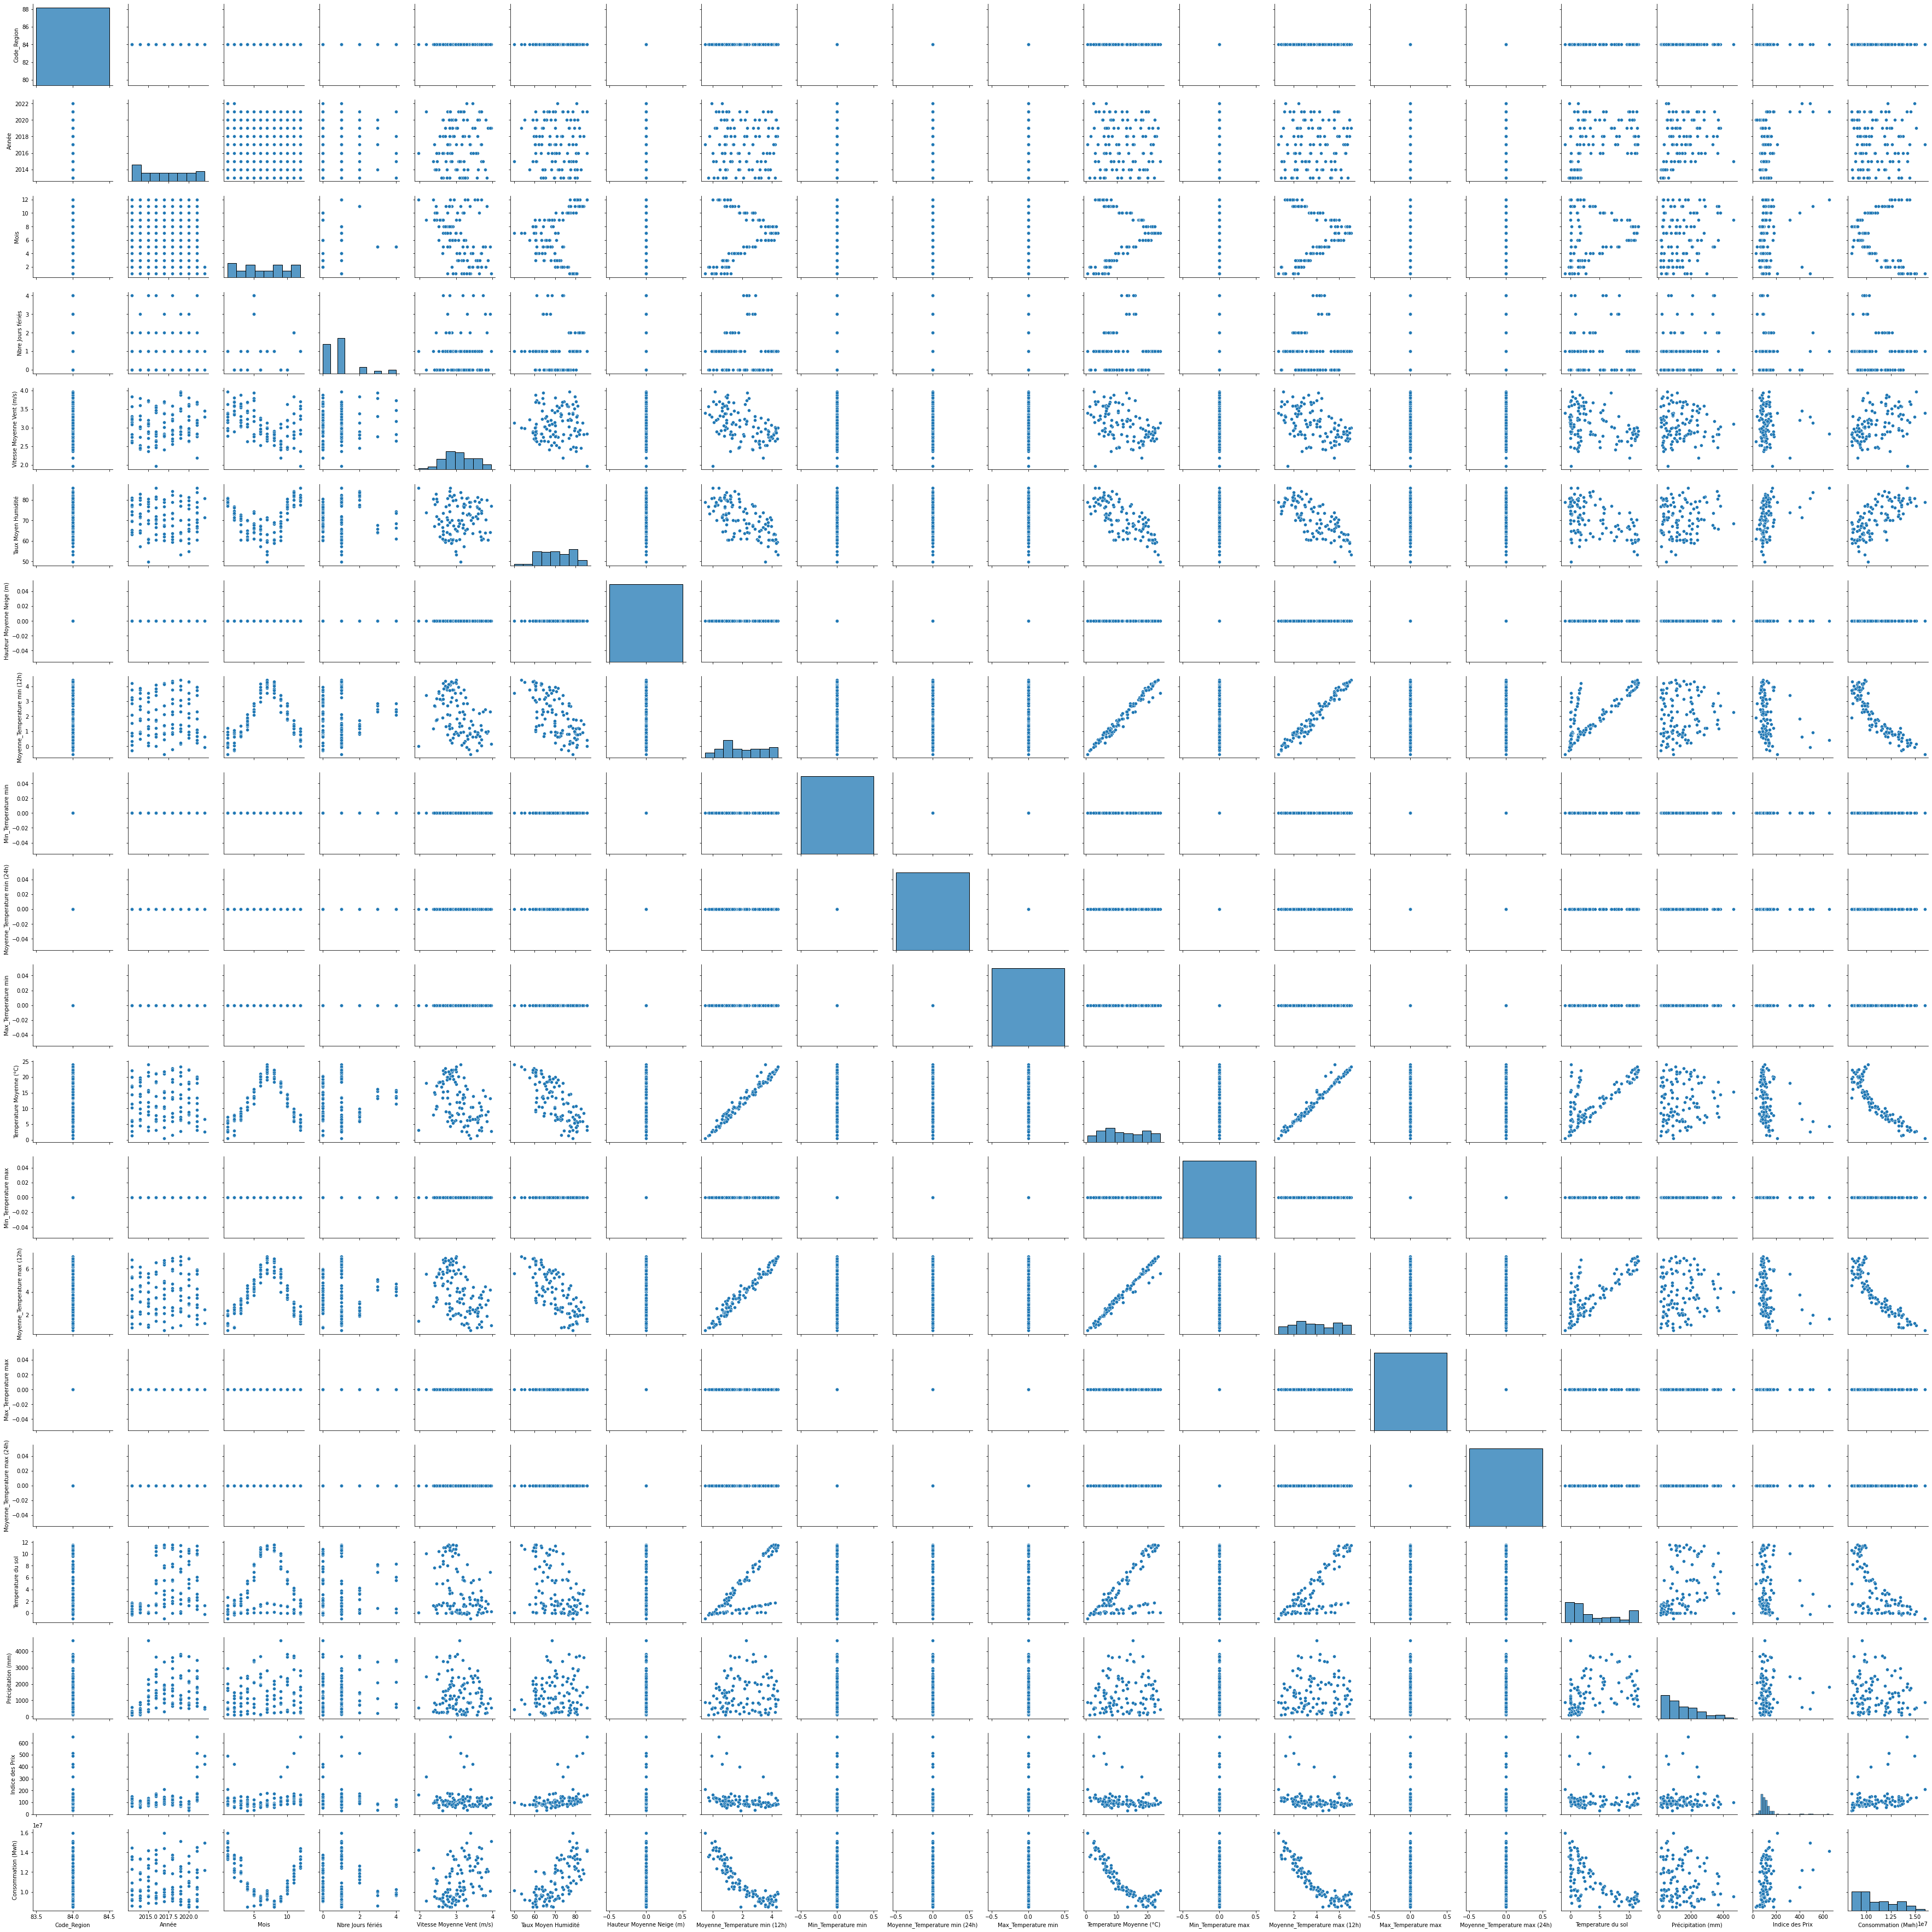

In [ ]:
sns.pairplot(elect.loc[elect['Code_Region']==code[0]]);

En cliquant sur la **dernière ligne** de cette matrice on peut observer en l'analysant que, des relations assez claires semblent être mises en évidence entre la consommation d'électricité et les certaines variables dont le mois et certaines températures.

Pour y voir un peu plus clair, nous allons repésenter **la matrice de corrélation** associée à chaque région.

####**Affichage des matrices de corrélation par région**

In [ ]:
# Liste des régions
region = ['Auvergne-Rhône-Alpe' ,'Bourgogne-Franche-Comté', 'Bretagne', 'Centre Val de Loire',
          'Grand Est', 'Hauts-De-France', 'Ile-De-France', 'Normandie','Nouvelle Aquitaine', 
          'Occitanie', 'Pays de la Loire', 'Provence Alpes Côte d\'Azur']

# Liste des noms courts des régions
shortRegion = ['AuvergneRA' ,'BourgogneFC', 'Bretagne', 'CentreVL', 'GrandEst', 'HautsDF', 'IleDF', 'Normandie', 'NouvelleAq', 'Occitanie', 'PaysLoire', 'PACA']

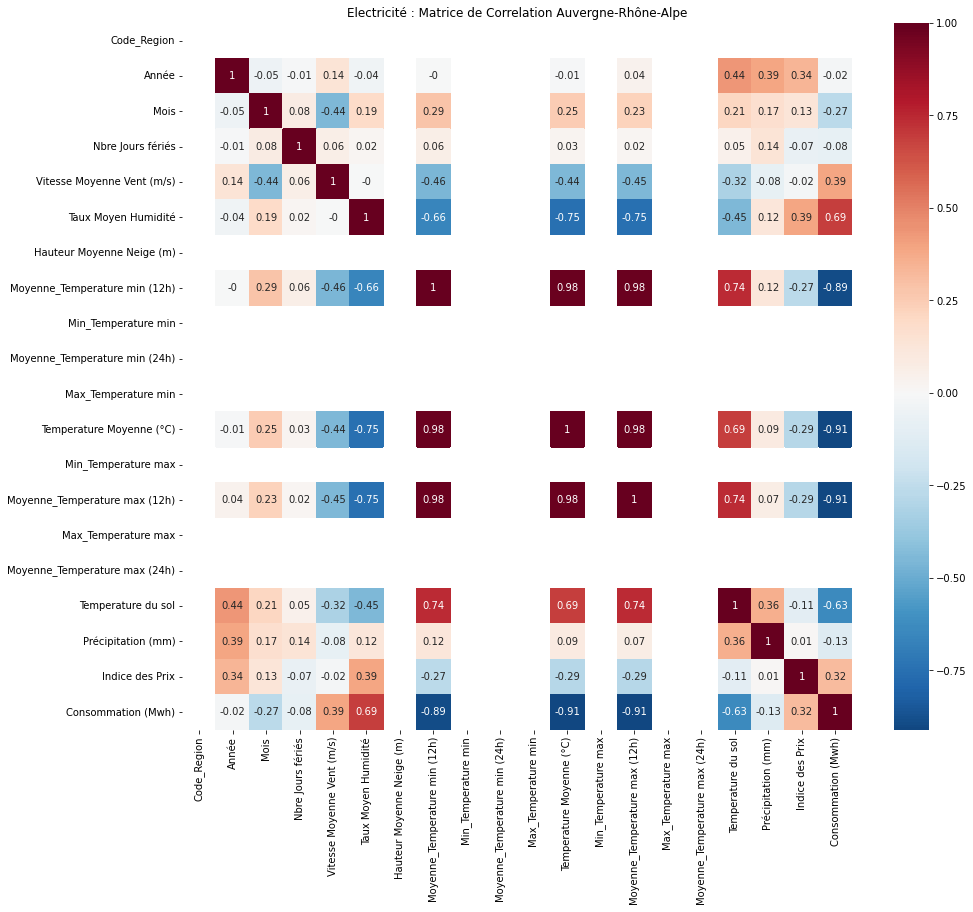

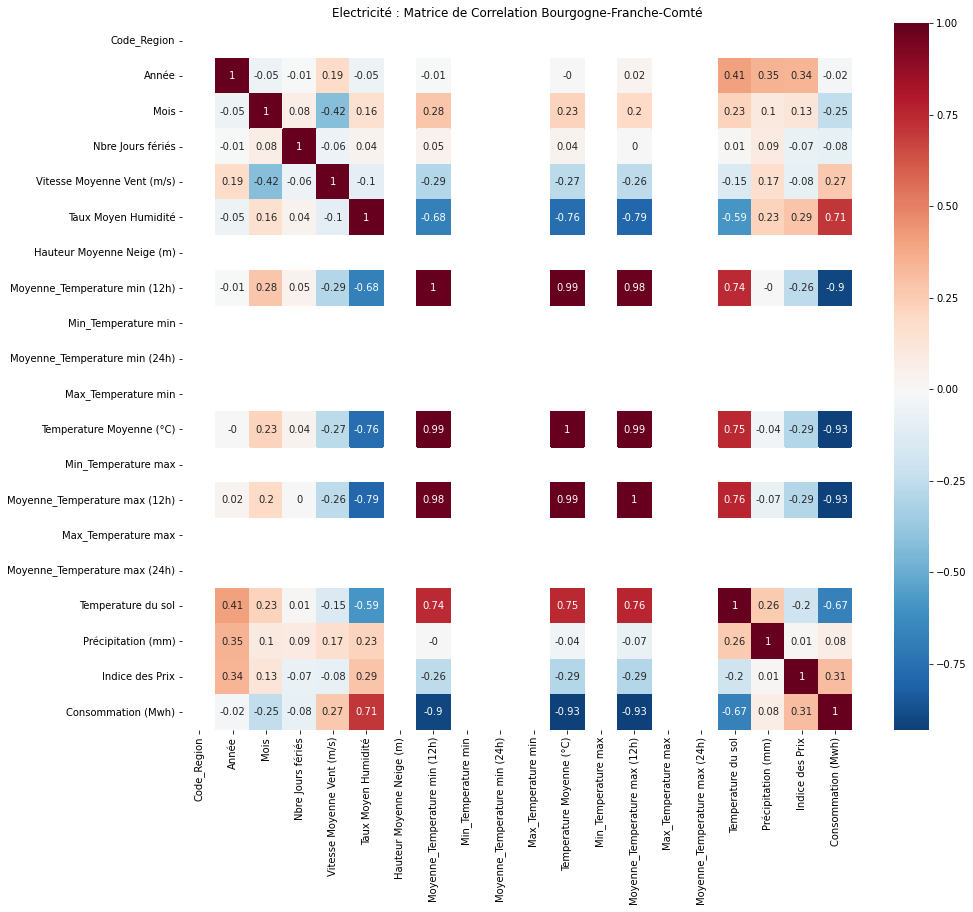

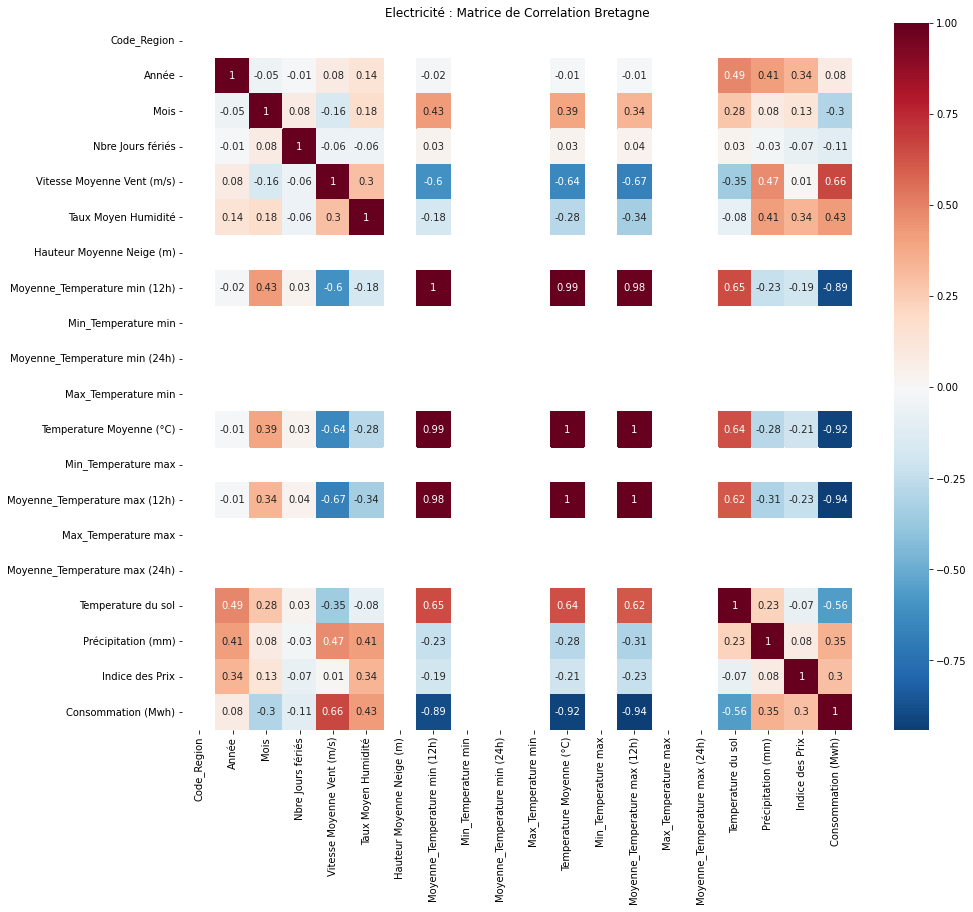

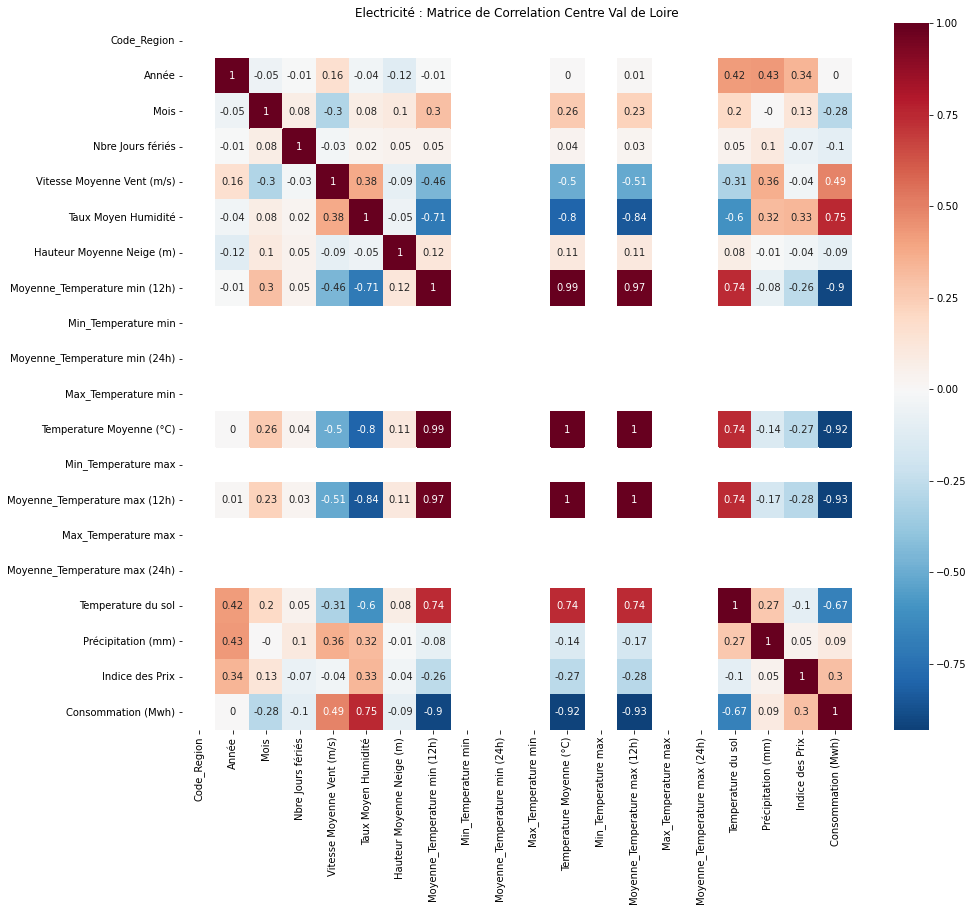

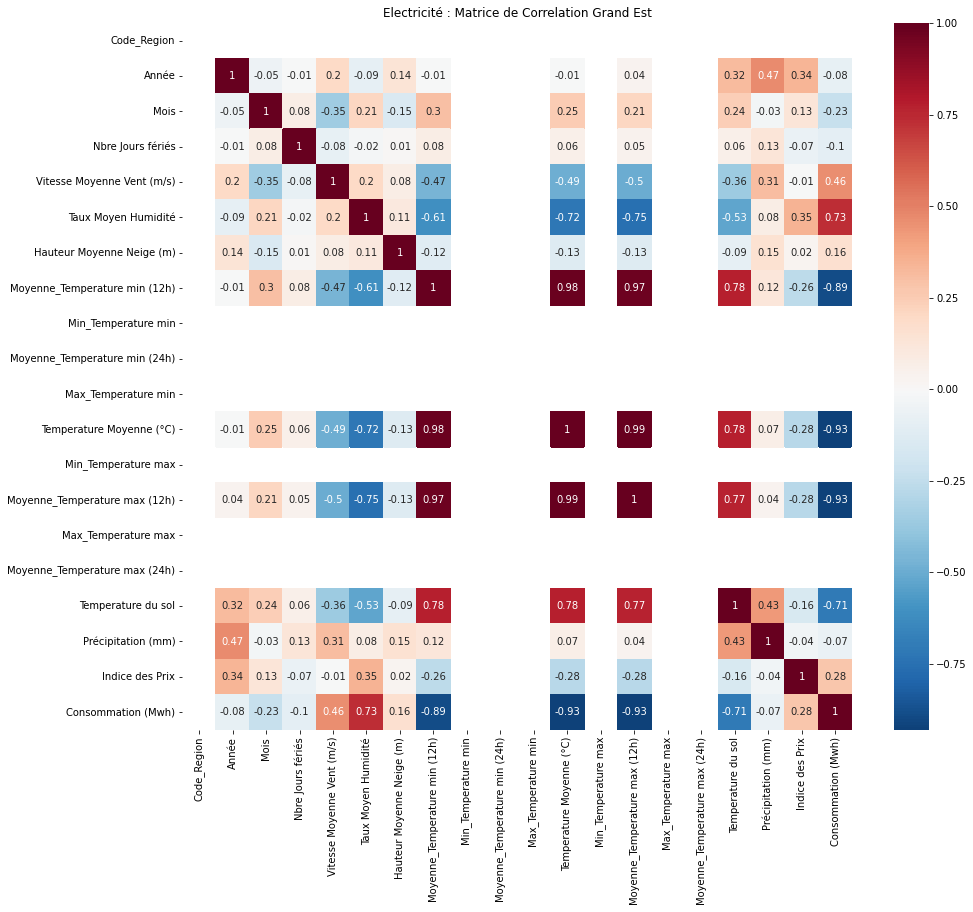

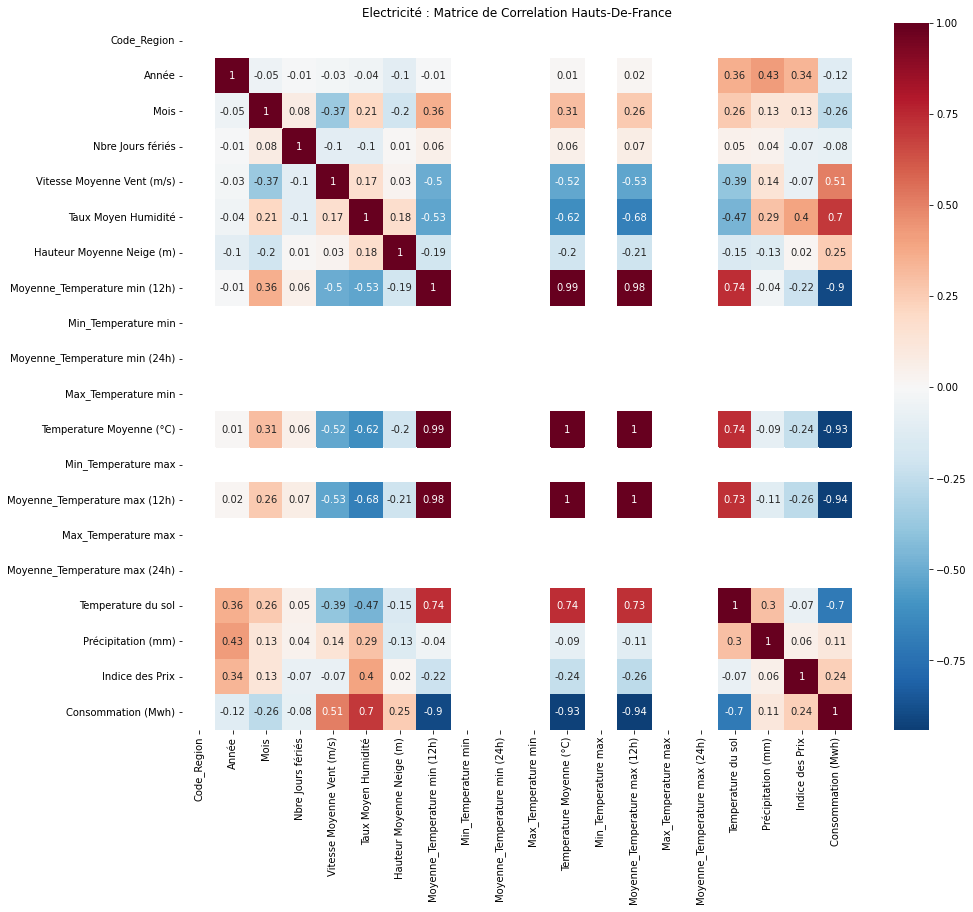

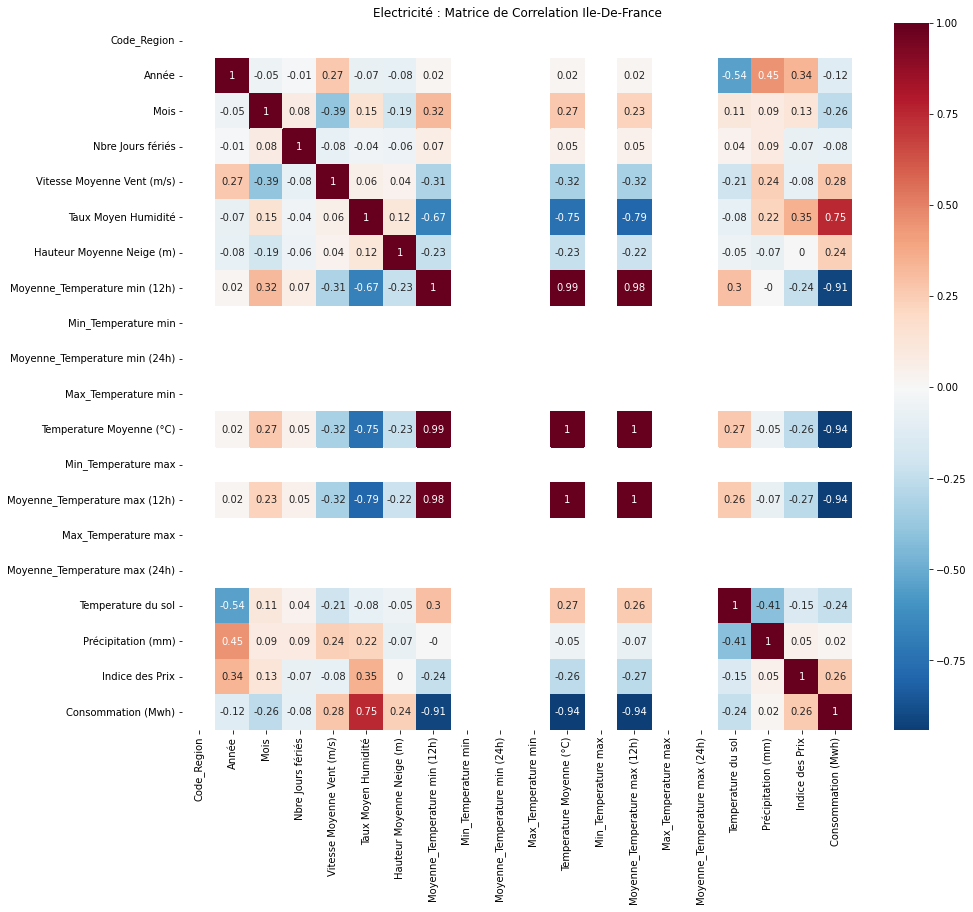

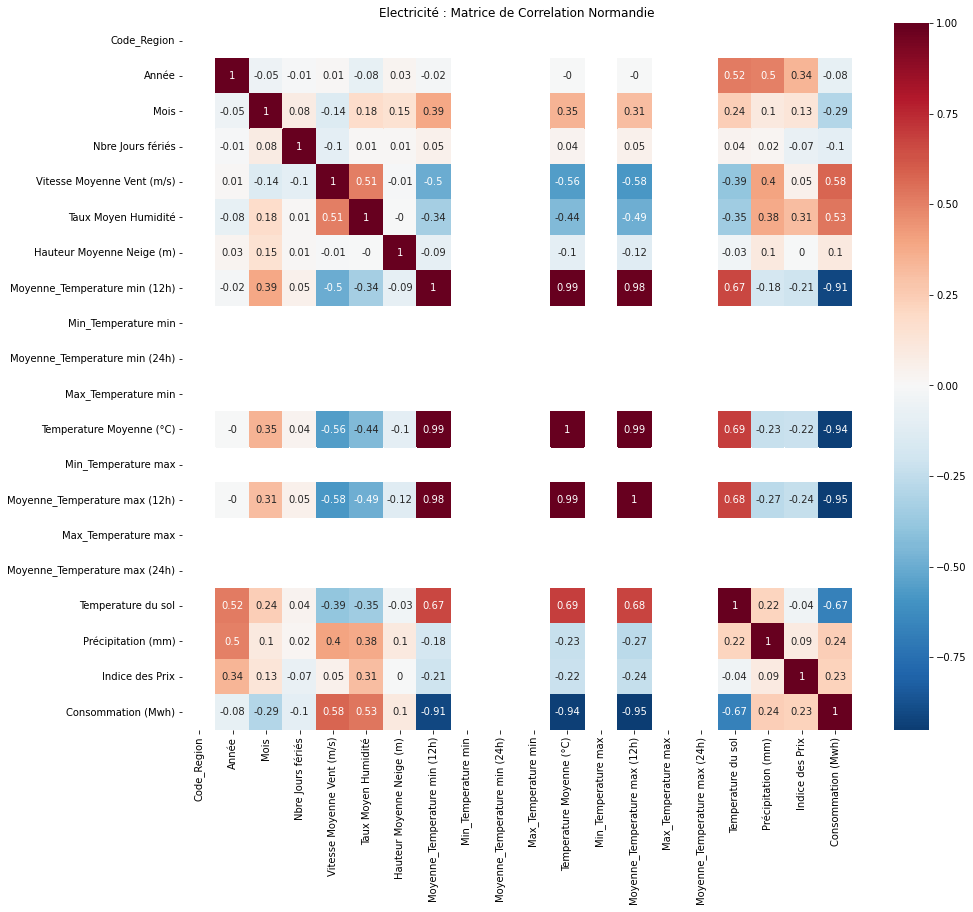

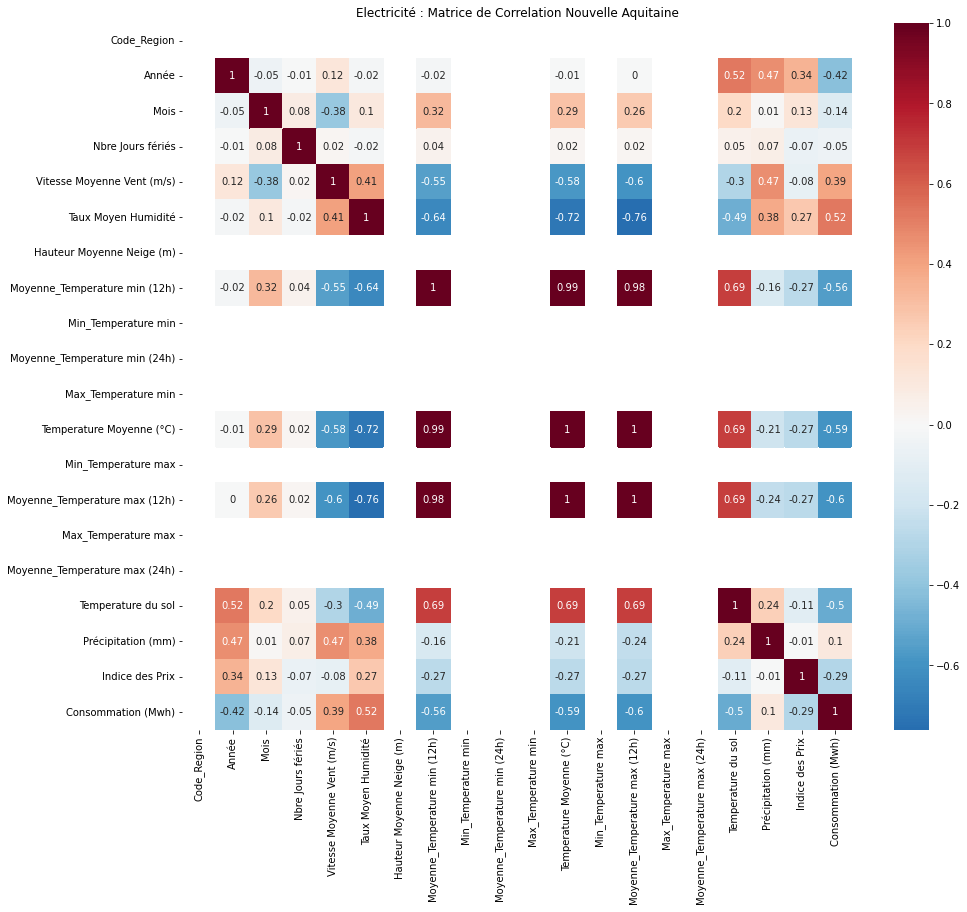

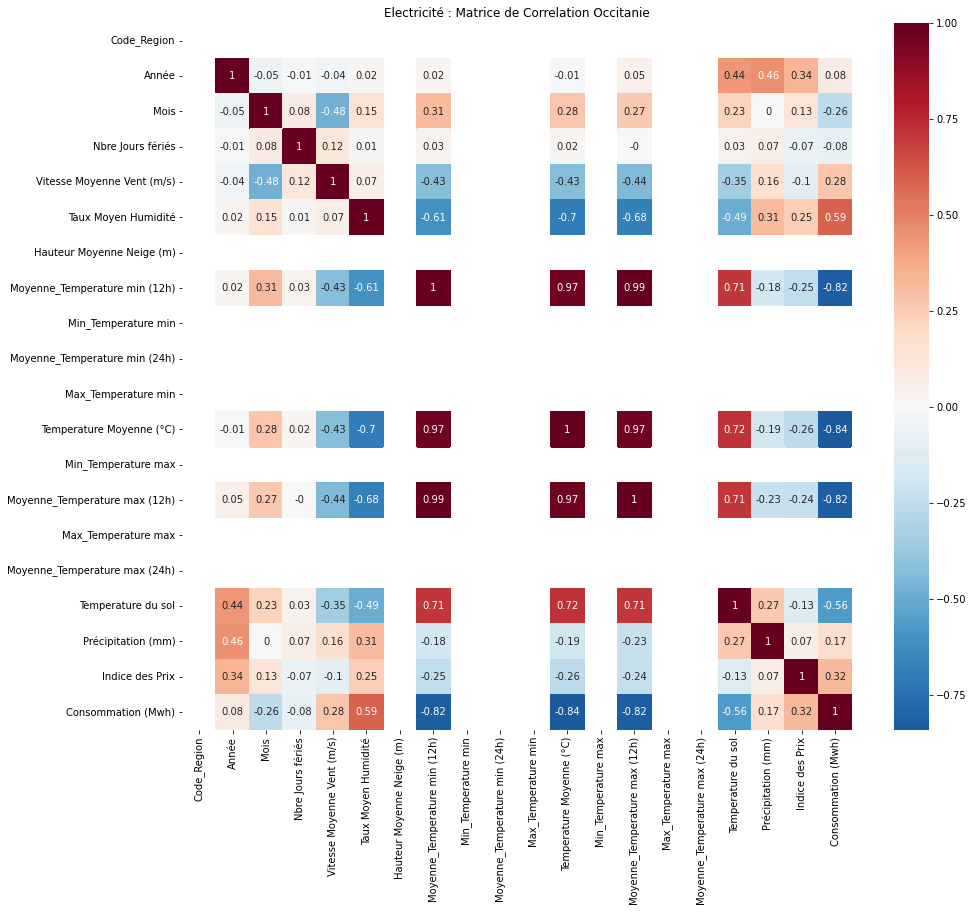

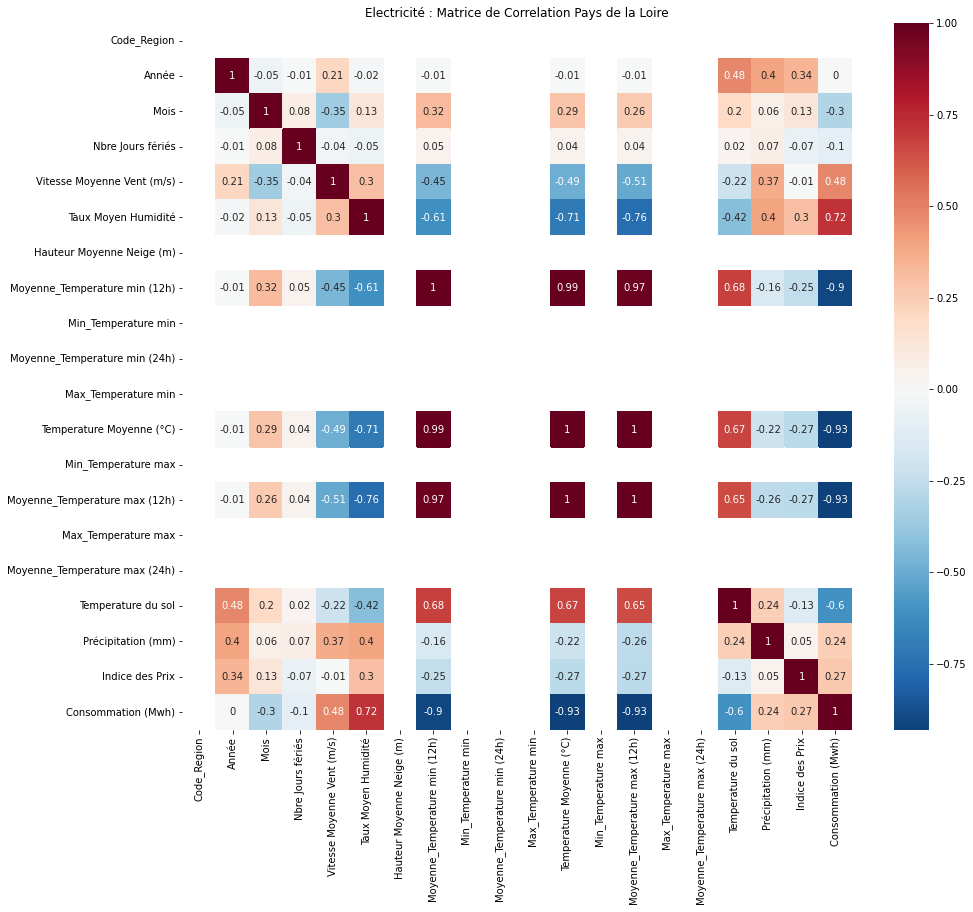

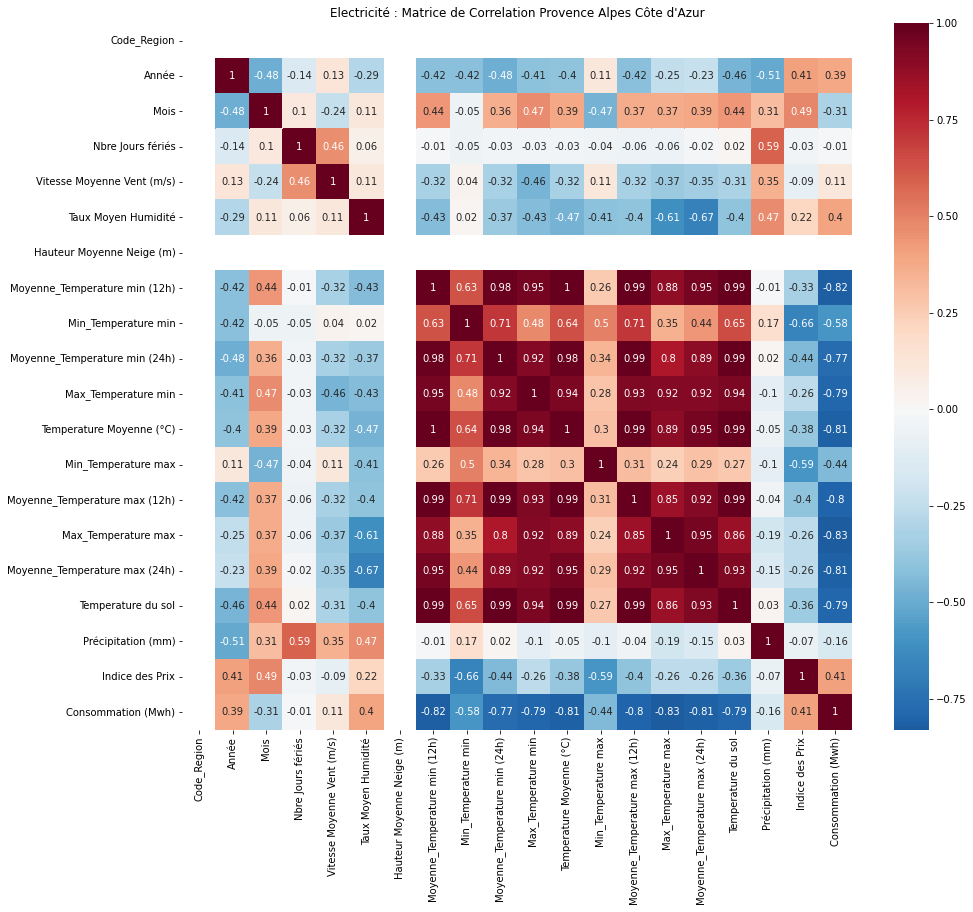

In [ ]:
# Affichage et sauvegarde des matrices de corrélation régionnales
      # Ce bout de code exécute une boucle qui construit un jeu de donnée correspondant à chaque région, un titre et un chemin de sauvegarde
      # puis, génère dans une figure la matrice de corrélation associé à chaque région
      # et enfin, affiche et stocke le graphique généré à l'emplacement indiqué.
      
      
for i in range(len(code)):

  df_region = elect.loc[elect['Code_Region']==code[i]]                                                       # Données de la région
  title = 'Electricité : Matrice de Correlation '+ region[i]                                                 # Titre
  path = 'gdrive/MyDrive/PFE_Models/Electricité_'+ shortRegion[i] + '_Correlation_Matrix.png'                # Chemin de sauvegarde

  fig, ax = plt.subplots(figsize = (15, 13))                                                                 # Construction de le figure
  ax = sns.heatmap(df_region.corr().round(2), annot=True, cmap = 'RdBu_r', center=0)                         # Matrice de corrélation régionale
  plt.title(title)                                                                                           # Ajout du titre au graphique
  fig.savefig(path)                                                                                          # Sauvegarde du graphique
  plt.show();

On peut noter que la tendance se confirme et qu'au final très peu de variables ont une influence forte sur la consommation d'éléctricité. Ce sont globalement, la région à travers "***Code_Région***", le ***mois***, le ***Taux d'humidité***, la ***moyenne des températures min (12h)***, la ***température moyenne***, la ***moyenne des températures max (12h)***, la ***température du sol***. 

Pour la construction de notre modèle et compte tenu des contraintes telles que : 
> 1. nombre maximal de variables explicatives fixé à 7 dans l'environnement de production;
> 2. utilisation d'au moins une variable financière comme variable explicative;

nous avons fait le choix de remplacer la variable ***moyenne des températures min (12h)*** par l'***Indice des prix*** de l'éléctricité.


Ce sont donc ces variables que nous utiliserons pour construire notre modèle de prédiction.

##**4. Construction du modèle**



> Le modèle que nous construisons est un modèle de type pipeline qui entrainera sur les données, plusieurs modèles **SVR** de noyau **'rbf'** et procèdra par une validation croisée de ceux-ci grâce à une grille de recherche, à la sélection du modèle le plus performant.



In [ ]:
# Identification de la variable cible à prédire (target) et des variables explicatives les plus correlées.
target = elect["Consommation (Mwh)"]
data = elect.drop(["Consommation (Mwh)", "Année", "Nbre Jours fériés",
                   "Hauteur Moyenne Neige (m)", "Vitesse Moyenne Vent (m/s)", "Min_Temperature min",
                   "Moyenne_Temperature min (12h)", "Moyenne_Temperature min (24h)", "Max_Temperature min",
                   "Min_Temperature max", "Max_Temperature max", "Moyenne_Temperature max (24h)", "Précipitation (mm)"], axis = 1)


#Séparation des données en jeux d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2,  random_state=101)


# Construction du modèle

## Le mapper indique les différentes opérations qui seront appliquées à chacune des colonnes du jeux de données dans le modèle avant entrainement.
mapper = DataFrameMapper([
    (["Code_Region", "Mois"], None),
    (["Taux Moyen Humidité", "Temperature Moyenne (°C)", "Moyenne_Temperature max (12h)", "Temperature du sol", "Indice des Prix"], StandardScaler())
    ])

# Modèle de base
rbf = svm.SVR(kernel='rbf', gamma=0.02, epsilon=0.1)

# Pipeline
pipeline = PMMLPipeline([
    ("mapping", mapper),
    ("Regressor", rbf)
])


params = {
    "Regressor__C": [0.001, 0.01, 0.15, 0.1, 0.2, 1, 10, 100, 1000, 10000, 1e5, 2e6, 3e6 ,1e6, 1e7],
    "Regressor__gamma": [0.00001, 0.0001, 0.001, 0.1, 0.2, 0.5]
}

# Grille de recherche du meilleur modèle par validation croisée
model = GridSearchCV(estimator = pipeline, param_grid = params, cv=9)

# Entrainement du modèle
model.fit(x_train, y_train)

GridSearchCV(cv=9,
             estimator=PMMLPipeline(steps=[('mapping', DataFrameMapper(features=[(['Code_Region', 'Mois'], None), (['Taux Moyen Humidité', 'Temperature Moyenne (°C)', 'Moyenne_Temperature max (12h)', 'Temperature du sol', 'Indice des Prix'], StandardScaler())])), ('Regressor', SVR(gamma=0.02))]),
             param_grid={'Regressor__C': [0.001, 0.01, 0.15, 0.1, 0.2, 1, 10,
                                          100, 1000, 10000, 100000.0, 2000000.0,
                                          3000000.0, 1000000.0, 10000000.0],
                         'Regressor__gamma': [1e-05, 0.0001, 0.001, 0.1, 0.2,
                                              0.5]})

###**Identification du meillleur modèle**

In [ ]:
#Récupération du meilleur modèle obtenu après validation croisée et affichage des paramètres optimaux de ce modèle.
best_pipeline = model.best_estimator_

best_pipeline

PMMLPipeline(steps=[('mapping', DataFrameMapper(features=[(['Code_Region', 'Mois'], None),
                          (['Taux Moyen Humidité', 'Temperature Moyenne (°C)',
                            'Moyenne_Temperature max (12h)',
                            'Temperature du sol', 'Indice des Prix'],
                           StandardScaler())])),
       ('Regressor', SVR(C=10000000.0, gamma=0.1))])

In [ ]:
# Calcul et Affiche du score de prédiction sur le jeu de données de validation
best_pipeline.score(x_test, y_test)

0.9408072400888569

###**Calcul des préditions, des métriques et sauvegarde du modèle au format *.pmml***

In [ ]:
# Prédiction du modèle. Cette prédiction est tockée dans une variable pour une utilisation ultérieure. 
y_pipe = best_pipeline.predict(x_test)

# Calcul des métriques

RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_pipe)),'.3f'))
MSE = mean_squared_error(y_test, y_pipe)
r2 = r2_score(y_test, y_pipe)

print("Electricity Root Mean Squared Error : ", RMSE)
print("Electricity Mean Squared Error : ", MSE)
print("Electricity R2 : ", r2)

Electricity Root Mean Squared Error :  853478.642
Electricity Mean Squared Error :  728425792801.8815
Electricity R2 :  0.9408072400888569


In [ ]:
# Prédiction du modèle. Cette prédiction est tockée dans ne variable pour une utilisation ultérieure. 
y_pipe = best_pipeline.predict(x_test)


# Conversion du modèle entraîné en fichier pmml. Le fichier sera importé dans l'outil IPM pour y être déployé et mis en production
sklearn2pmml(best_pipeline, "/content/gdrive/MyDrive/PFE_Models/06062022ElectricitySVR_model.pmml", with_repr = True)

##**5. Comparaisons prédictions vs données réelles**

In [ ]:
# Comparaison des valeurs prédites et des valeurs réelles

compare = pd.DataFrame({'Consommation Elect' : y_test, 'Model_prediction':y_pipe}, index = y_test.index).sort_values(by=['Consommation Elect'],
                                                                                                                     ascending=False)
# Affichage des 10 premières valeurs 
compare.head(10)

Consommation Elect  Model_prediction
668             17976376      1.705263e+07
30              17306560      1.572179e+07
6               16826536      1.633407e+07
162             15999660      1.485232e+07
28              15582496      1.464518e+07
1206            15419568      1.164440e+07
127             15381275      1.517002e+07
1200            14938048      1.169139e+07
1042            14533008      1.499860e+07
0               14455649      1.451258e+07

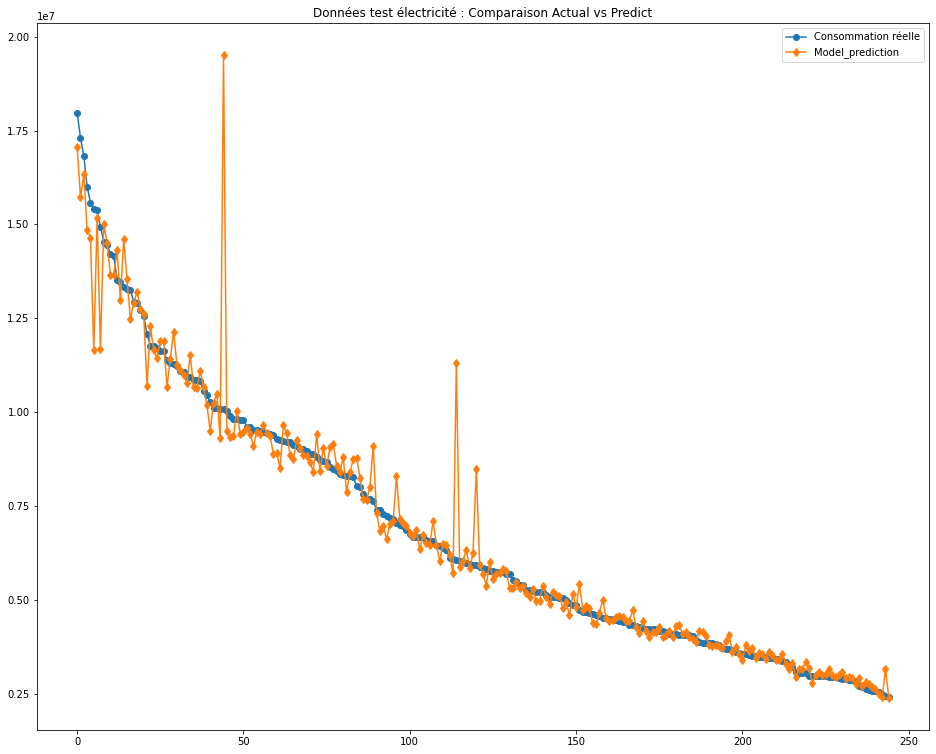

In [ ]:
fig = plt.figure(figsize=(16,13))

plt.plot(range(compare.shape[0]), compare['Consommation Elect'], '-o' ,label='Consommation réelle')
plt.plot(range(compare.shape[0]), compare['Model_prediction'], '-d',label='Model_prediction')
plt.title('Données test électricité : Comparaison Actual vs Predict')
fig.savefig('gdrive/MyDrive/PFE_Models/Electricite Comparaison Actual vs Predict.png')
plt.legend()
plt.show();

In [ ]:
pred = x_test.join(compare, on=y_test.index).sort_values(by=['Consommation Elect'], ascending=False)
pred.head(20)

Code_Region  Mois  Taux Moyen Humidité  Temperature Moyenne (°C)  \
668            75     1                91.02                      8.60   
30             75     3                75.72                      7.86   
6              11     1                87.77                      3.44   
162            75     3                73.43                      9.77   
28             11     3                74.06                      4.82   
1206           11     1                88.95                      4.56   
127            11    12                83.71                      5.48   
1200           84     1                80.68                      2.49   
1042           75    11                81.03                     10.76   
0              84     1                81.05                      2.78   
517            84    12                85.68                      3.06   
116            11    11                83.98                      7.16   
149            11     2                79.92                      7.01   
660            84     1                78.77                      7.23   
545            11     2                78.61                      6.86   
132            84     1                79.96                      6.21   
418            84     3                71.89                      6.53   
866            75     7                65.56                     22.42   
1045           84    12                81.15                      5.48   
470            75     7                69.76                     20.39   

      Moyenne_Temperature max (12h)  Temperature du sol  Indice des Prix  \
668                            2.56                5.22             79.0   
30                             2.75                0.26            152.4   
6                              1.18                0.02            133.7   
162                            3.35                0.23             98.0   
28                             1.81                0.03            152.4   
1206                           1.60                0.00            490.9   
127                            1.92                0.08            134.1   
1200                           1.28               -0.20            490.9   
1042                           3.47                6.51             92.4   
0                              1.22               -0.15            133.7   
517                            1.49                0.06            166.8   
116                            2.24                0.50            132.5   
149                            2.35                0.35            103.9   
660                            2.37                2.62             79.0   
545                            2.35                0.00            136.6   
132                            2.11                0.22            105.6   
418                            2.47                1.37             74.0   
866                            6.68               13.31             86.3   
1045                           1.89                2.18            111.8   
470                            6.11                8.37             80.9   

      Consommation Elect  Model_prediction  
668             17976376      1.705263e+07  
30              17306560      1.572179e+07  
6               16826536      1.633407e+07  
162             15999660      1.485232e+07  
28              15582496      1.464518e+07  
1206            15419568      1.164440e+07  
127             15381275      1.517002e+07  
1200            14938048      1.169139e+07  
1042            14533008      1.499860e+07  
0               14455649      1.451258e+07  
517             14217542      1.364352e+07  
116             14152841      1.365175e+07  
149             13530928      1.430621e+07  
660             13476522      1.299827e+07  
545             13337869      1.459821e+07  
132             13284005      1.355395e+07  
418             13262139      1.248274e+07  
866             12936570      1.291272e+07  